In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
from src.styles import set_plot_style
from src.plots import *
from src.timeline import *
from src.utils import load_and_prepare_metadata
set_plot_style("prism_rain")
from src.utils import _proc_from_path, _file_index, _read_measurement
import polars as pl

saved figs/Encap81_IVg_sequence_metadata.png


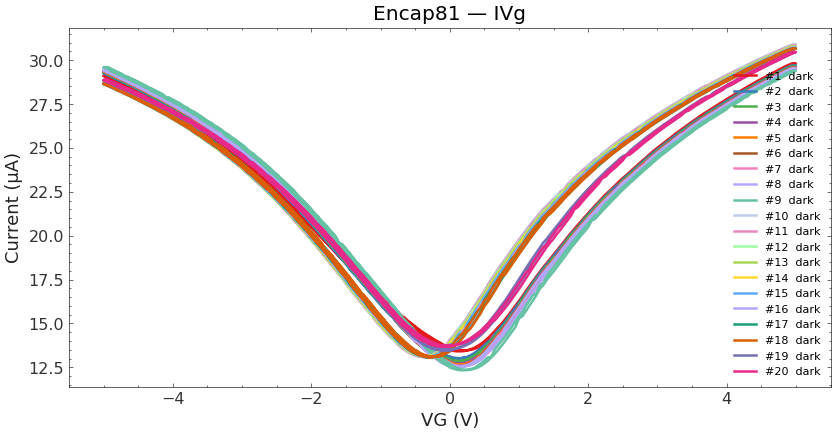

In [2]:
METADATA_CSV = "metadata/Alisson_25_sept/metadata.csv"        # path to the table you pasted
BASE_DIR     = Path(".")             # where the raw CSVs live, e.g. "Alisson_04_sept/"
CHIP_NUMBER  = 81.0 
meta = load_and_prepare_metadata(METADATA_CSV, CHIP_NUMBER)
tag = Path(METADATA_CSV).stem


# Reuse your existing plotter on this subset
plot_ivg_sequence(meta, BASE_DIR, tag) 

In [3]:
def plot_its_overlay(df: pl.DataFrame, base_dir: Path, tag: str, baseline_t: float = 60.0):
    import numpy as np

    # --- small helper to extract wavelength in nm from a metadata row ---
    def _get_wavelength_nm(row: dict) -> float | None:
        candidates = [
            "Laser wavelength", "lambda", "lambda_nm", "wavelength", "wavelength_nm",
            "Wavelength", "Wavelength (nm)", "Laser wavelength (nm)", "Laser λ (nm)"
        ]
        for k in candidates:
            if k in row:
                try:
                    val = float(row[k])
                    if np.isfinite(val):
                        return val
                except Exception:
                    pass
        # Sometimes wavelength is stored as meters:
        for k in ["Wavelength (m)", "lambda_m"]:
            if k in row:
                try:
                    val = float(row[k]) * 1e9
                    if np.isfinite(val):
                        return val
                except Exception:
                    pass
        return None

    its = df.filter(pl.col("proc") == "ITS").sort("file_idx")
    if its.height == 0:
        print("[warn] no ITS rows in metadata")
        return

    plt.figure()
    curves_plotted = 0

    t_totals = []
    starts_vl, ends_vl = [], []
    on_durations_meta = []

    for row in its.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists():
            print(f"[warn] missing file: {path}")
            continue

        d = _read_measurement(path)
        if not {"t", "I"} <= set(d.columns):
            print(f"[warn] {path} lacks t/I; got {d.columns}")
            continue

        tt = np.asarray(d["t"])
        yy = np.asarray(d["I"])
        if tt.size == 0 or yy.size == 0:
            print(f"[warn] empty/invalid series in {path}")
            continue
        if not np.all(np.diff(tt) >= 0):
            idx = np.argsort(tt)
            tt = tt[idx]; yy = yy[idx]

        # baseline @ baseline_t
        if tt[0] <= baseline_t <= tt[-1]:
            I0 = float(np.interp(baseline_t, tt, yy))
        else:
            nearest_idx = int(np.argmin(np.abs(tt - baseline_t)))
            I0 = float(yy[nearest_idx])
            print(f"[info] {path.name}: baseline_t={baseline_t:g}s outside [{tt[0]:.3g},{tt[-1]:.3g}]s; "
                  f"used nearest t={tt[nearest_idx]:.3g}s")
        yy_corr = yy - I0

        # --- label: wavelength only ---
        wl = _get_wavelength_nm(row)
        if wl is not None:
            lbl = f"{wl:g} nm"
        else:
            lbl = f"#{int(row['file_idx'])}"  # fallback if wavelength missing

        plt.plot(tt, yy_corr*1e6, label=lbl)
        curves_plotted += 1

        try:
            t_totals.append(float(tt[-1]))
        except Exception:
            pass

        if "VL" in d.columns:
            try:
                vl = np.asarray(d["VL"])
                on_idx = np.where(vl > 0)[0]
                if on_idx.size:
                    starts_vl.append(float(tt[on_idx[0]]))
                    ends_vl.append(float(tt[on_idx[-1]]))
            except Exception:
                pass

        if "Laser ON+OFF period" in its.columns:
            try:
                on_durations_meta.append(float(row["Laser ON+OFF period"]))
            except Exception:
                pass

    if curves_plotted == 0:
        print("[warn] no ITS traces plotted; skipping light-window shading")
        return

    if t_totals:
        T_total = float(np.median(t_totals))
        if np.isfinite(T_total) and T_total > 0:
            plt.xlim(20, T_total)

    t0 = t1 = None
    if starts_vl and ends_vl:
        t0 = float(np.median(starts_vl)); t1 = float(np.median(ends_vl))
    if (t0 is None or t1 is None) and on_durations_meta and t_totals:
        on_dur = float(np.median(on_durations_meta))
        T_total = float(np.median(t_totals))
        if np.isfinite(on_dur) and np.isfinite(T_total) and T_total > 0:
            pre_off = max(0.0, (T_total - on_dur) / 2.0)
            t0 = pre_off; t1 = pre_off + on_dur
    if (t0 is None or t1 is None) and t_totals:
        T_total = float(np.median(t_totals))
        if np.isfinite(T_total) and T_total > 0:
            t0 = T_total / 3.0; t1 = 2.0 * T_total / 3.0
    if (t0 is not None) and (t1 is not None) and (t1 > t0):
        plt.axvspan(t0, t1, alpha=0.15)

    plt.xlabel("t (s)")
    plt.ylabel(f"ΔCurrent (µA)")
    plt.title(f"Chip {int(df['Chip number'][0])} — ITS overlay")
    plt.legend(fontsize=8, title="Wavelength")
    plt.tight_layout()
    out = FIG_DIR / f"chip{int(df['Chip number'][0])}_ITS_overlay_{tag}.png"
    plt.savefig(out, dpi=200)
    print(f"saved {out}")


saved figs/chip81_ITS_overlay_metadata.png


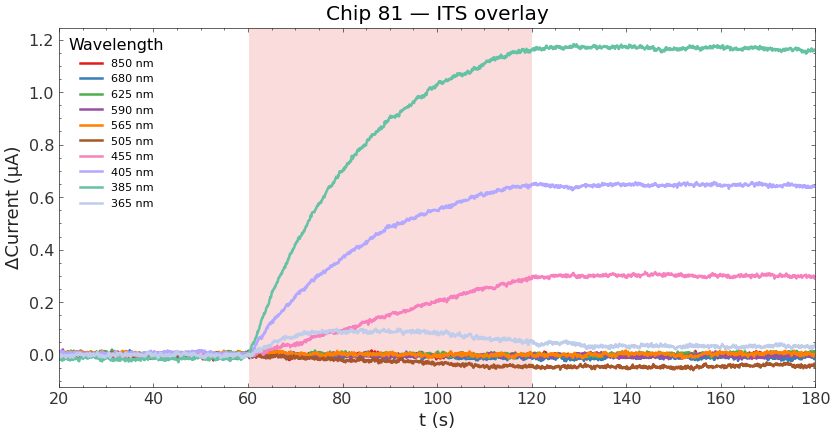

In [4]:
good_its = [1,2,3,4,5,6,7,8,15,16]  # the _NN.csv numbers you want

meta_only_good_it= meta.filter(
    (pl.col("proc") == "ITS") & pl.col("file_idx").is_in(good_its)
)

# Reuse your existing plotter on this subset
plot_its_overlay(meta_only_good_it, BASE_DIR, tag)

[warn] raw_data/Alisson_25_sept/It2025-09-25_10.csv lacks t/I; got []
saved figs/chip81_ITS_overlay_metadata.png


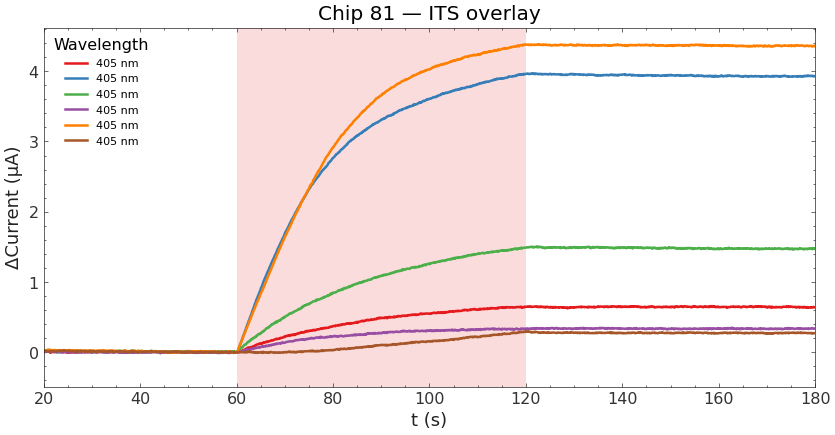

In [5]:
good_its = [8,9,10,11,12,13,14]  # the _NN.csv numbers you want

meta_only_good_it= meta.filter(
    (pl.col("proc") == "ITS") & pl.col("file_idx").is_in(good_its)
)

# Reuse your existing plotter on this subset
plot_its_overlay(meta_only_good_it, BASE_DIR, tag)

saved figs/chip81_ITS_overlay_metadata.png


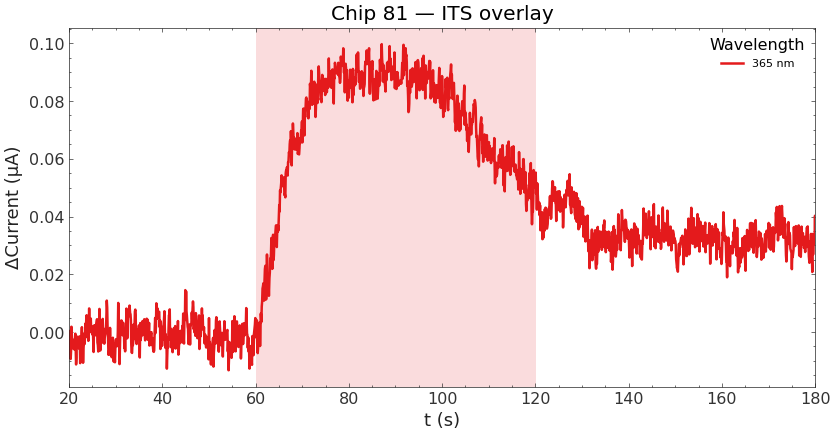

In [6]:
good_its = [16]  # the _NN.csv numbers you want

meta_only_good_it= meta.filter(
    (pl.col("proc") == "ITS") & pl.col("file_idx").is_in(good_its)
)

# Reuse your existing plotter on this subset
plot_its_overlay(meta_only_good_it, BASE_DIR, tag)

In [7]:
def plot_its_overlay(
    df: pl.DataFrame,
    base_dir: Path,
    tag: str,
    baseline_t: float = 60.0,
    *,
    legend_by: str = "wavelength",  # "wavelength" (default) or "vg"
):
    """
    Overlay ITS traces baseline-corrected at `baseline_t`.
    Parameters
    ----------
    legend_by : {"wavelength","vg"}
        Use wavelength labels like "365 nm" (default) or gate voltage labels like "3 V".
        Aliases accepted: "wl","lambda" -> wavelength; "gate","vg","vgs" -> vg.
    """
    import numpy as np
    # import matplotlib.pyplot as plt  # uncomment if not imported elsewhere

    # --- normalize legend_by to a canonical value ---
    lb = legend_by.strip().lower()
    if lb in {"wavelength", "wl", "lambda"}:
        lb = "wavelength"
    elif lb in {"vg", "gate", "vgs"}:
        lb = "vg"
    else:
        print(f"[info] legend_by='{legend_by}' not recognized; using wavelength")
        lb = "wavelength"

    # --- small helper to extract wavelength in nm from a metadata row ---
    def _get_wavelength_nm(row: dict) -> float | None:
        candidates = [
            "Laser wavelength", "lambda", "lambda_nm", "wavelength", "wavelength_nm",
            "Wavelength", "Wavelength (nm)", "Laser wavelength (nm)", "Laser λ (nm)"
        ]
        for k in candidates:
            if k in row:
                try:
                    val = float(row[k])
                    if np.isfinite(val):
                        return val
                except Exception:
                    pass
        # Sometimes wavelength is stored as meters:
        for k in ["Wavelength (m)", "lambda_m"]:
            if k in row:
                try:
                    val = float(row[k]) * 1e9
                    if np.isfinite(val):
                        return val
                except Exception:
                    pass
        return None

    # --- helper to extract Vg in volts from metadata row or from the data trace if constant ---
    def _get_vg_V(row: dict, d: "pl.DataFrame | dict | None" = None) -> float | None:
        # 1) Try metadata with common key variants
        vg_keys = [
            "VG", "Vg", "VGS", "Vgs", "Gate voltage", "Gate Voltage",
            "VG (V)", "Vg (V)", "VGS (V)", "Gate voltage (V)",
            "VG setpoint", "Vg setpoint", "Gate setpoint (V)", "VG bias (V)"
        ]
        # direct numeric first
        for k in vg_keys:
            if k in row:
                try:
                    val = float(row[k])
                    if np.isfinite(val):
                        return val
                except Exception:
                    pass
        # permissive: numeric when key contains 'vg' or 'gate'
        for k, v in row.items():
            kl = str(k).lower()
            if ("vg" in kl or "gate" in kl):
                try:
                    val = float(v)
                    if np.isfinite(val):
                        return val
                except Exception:
                    # maybe a string like "VG=3.0 V"
                    try:
                        import re
                        m = re.search(r"([-+]?\d+(\.\d+)?)", str(v))
                        if m:
                            return float(m.group(1))
                    except Exception:
                        pass
        # 2) Try the data trace: if there's a nearly-constant VG column, use its median
        if d is not None and "VG" in d.columns:
            try:
                arr = np.asarray(d["VG"], dtype=float)
                if arr.size:
                    if np.nanstd(arr) < 1e-6:  # basically constant
                        return float(np.nanmedian(arr))
            except Exception:
                pass
        return None

    its = df.filter(pl.col("proc") == "ITS").sort("file_idx")
    if its.height == 0:
        print("[warn] no ITS rows in metadata")
        return

    plt.figure()
    curves_plotted = 0

    t_totals = []
    starts_vl, ends_vl = [], []
    on_durations_meta = []

    for row in its.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists():
            print(f"[warn] missing file: {path}")
            continue

        d = _read_measurement(path)
        if not {"t", "I"} <= set(d.columns):
            print(f"[warn] {path} lacks t/I; got {d.columns}")
            continue

        tt = np.asarray(d["t"])
        yy = np.asarray(d["I"])
        if tt.size == 0 or yy.size == 0:
            print(f"[warn] empty/invalid series in {path}")
            continue
        if not np.all(np.diff(tt) >= 0):
            idx = np.argsort(tt)
            tt = tt[idx]; yy = yy[idx]

        # baseline @ baseline_t
        if tt[0] <= baseline_t <= tt[-1]:
            I0 = float(np.interp(baseline_t, tt, yy))
        else:
            nearest_idx = int(np.argmin(np.abs(tt - baseline_t)))
            I0 = float(yy[nearest_idx])
            print(f"[info] {path.name}: baseline_t={baseline_t:g}s outside [{tt[0]:.3g},{tt[-1]:.3g}]s; "
                  f"used nearest t={tt[nearest_idx]:.3g}s")
        yy_corr = yy - I0

        # --- label based on legend_by ---
        if lb == "wavelength":
            wl = _get_wavelength_nm(row)
            if wl is not None:
                lbl = f"{wl:g} nm"
                legend_title = "Wavelength"
            else:
                lbl = f"#{int(row['file_idx'])}"
                legend_title = "Trace"
        else:  # lb == "vg"
            vg = _get_vg_V(row, d)
            if vg is not None:
                # Compact formatting: 3.0 → "3 V", 0.25 → "0.25 V"
                # Use :g to avoid trailing zeros, then add unit.
                lbl = f"{vg:g} V"
                legend_title = "Vg"
            else:
                lbl = f"#{int(row['file_idx'])}"
                legend_title = "Trace"

        plt.plot(tt, yy_corr * 1e6, label=lbl)
        curves_plotted += 1

        try:
            t_totals.append(float(tt[-1]))
        except Exception:
            pass

        if "VL" in d.columns:
            try:
                vl = np.asarray(d["VL"])
                on_idx = np.where(vl > 0)[0]
                if on_idx.size:
                    starts_vl.append(float(tt[on_idx[0]]))
                    ends_vl.append(float(tt[on_idx[-1]]))
            except Exception:
                pass

        if "Laser ON+OFF period" in its.columns:
            try:
                on_durations_meta.append(float(row["Laser ON+OFF period"]))
            except Exception:
                pass

    if curves_plotted == 0:
        print("[warn] no ITS traces plotted; skipping light-window shading")
        return

    if t_totals:
        T_total = float(np.median(t_totals))
        if np.isfinite(T_total) and T_total > 0:
            plt.xlim(20, T_total)

    t0 = t1 = None
    if starts_vl and ends_vl:
        t0 = float(np.median(starts_vl)); t1 = float(np.median(ends_vl))
    if (t0 is None or t1 is None) and on_durations_meta and t_totals:
        on_dur = float(np.median(on_durations_meta))
        T_total = float(np.median(t_totals))
        if np.isfinite(on_dur) and np.isfinite(T_total) and T_total > 0:
            pre_off = max(0.0, (T_total - on_dur) / 2.0)
            t0 = pre_off; t1 = pre_off + on_dur
    if (t0 is None or t1 is None) and t_totals:
        T_total = float(np.median(t_totals))
        if np.isfinite(T_total) and T_total > 0:
            t0 = T_total / 3.0; t1 = 2.0 * T_total / 3.0
    if (t0 is not None) and (t1 is not None) and (t1 > t0):
        plt.axvspan(t0, t1, alpha=0.15)

    plt.xlabel("t (s)")
    plt.ylabel("ΔCurrent (µA)")
    chipnum = int(df["Chip number"][0])  # keep your original pattern
    plt.title(f"Chip {chipnum} — ITS overlay")
    plt.legend(fontsize=8, title=legend_title)
    plt.tight_layout()
    out = FIG_DIR / f"chip{chipnum}_ITS_overlay_{tag}.png"
    plt.savefig(out, dpi=200)
    print(f"saved {out}")


saved figs/chip81_ITS_overlay_metadata.png


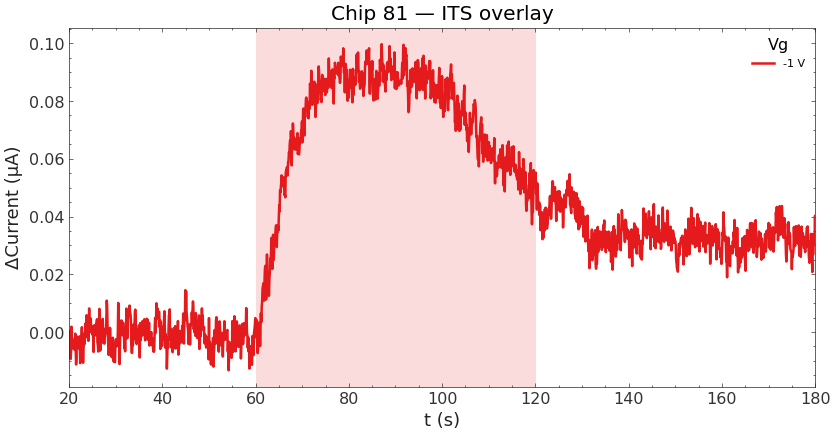

In [8]:
plot_its_overlay(meta_only_good_it, BASE_DIR, tag, baseline_t=60.0, legend_by="vg")

In [9]:
import numpy as np
import polars as pl
from pathlib import Path

def its_photocurrent_metrics(tt, yy, t0, t1, *, edge_frac=0.2, end_tail_s=10.0, smooth_win_s=1.0):
    assert t1 > t0
    on = (tt >= t0) & (tt <= t1)
    t_on, y_on = tt[on], yy[on]
    if t_on.size == 0:
        return None

    # rolling-median smoothing for peak (robust to noise)
    try:
        dt = np.median(np.diff(t_on))
        w = max(1, int(round(smooth_win_s / max(dt, 1e-6))))
        if w > 1:
            from numpy.lib.stride_tricks import sliding_window_view
            pads = w // 2
            ypad = np.pad(y_on, (pads, pads), mode="edge")
            sw = sliding_window_view(ypad, w)
            y_smooth = np.median(sw, axis=-1)[:y_on.size]
        else:
            y_smooth = y_on
    except Exception:
        y_smooth = y_on

    i_peak_idx = int(np.argmax(y_smooth))
    I_peak = float(y_smooth[i_peak_idx])
    t_peak = float(t_on[i_peak_idx])

    tail_mask = (t_on >= max(t0, t1 - end_tail_s))
    I_end = float(np.median(y_on[tail_mask])) if np.any(tail_mask) else float(y_on[-1])

    T_on = t1 - t0
    core_lo = t0 + 0.2 * T_on if edge_frac is None else t0 + edge_frac * T_on
    core_hi = t1 - 0.2 * T_on if edge_frac is None else t1 - edge_frac * T_on
    core_mask = (t_on >= core_lo) & (t_on <= core_hi) if core_hi > core_lo else on
    I_avg = float(np.median(y_on[core_mask]))

    Q_photo = float(np.trapezoid(y_on, t_on))
    f_decay = float(1.0 - (I_end / I_peak)) if I_peak != 0 else np.nan

    # simple exponential decay fit (optional/best-effort)
    tau = np.nan
    try:
        seg = (t_on >= t_peak) & (t_on <= t1)
        t_fit = t_on[seg]; y_fit = y_on[seg]
        if t_fit.size >= 5 and np.nanmax(y_fit) > 0:
            denom = (I_peak - I_end)
            z = (y_fit - I_end) / denom if denom != 0 else None
            if z is not None and np.all(z > 0):
                X = (t_fit - t_peak)
                slope, _ = np.polyfit(X, -np.log(z), 1)
                tau = 1.0 / slope if slope > 0 else np.nan
    except Exception:
        pass

    return {
        "I_peak_uA": I_peak * 1e6,
        "t_peak_s": t_peak,
        "I_end_uA": I_end * 1e6,
        "I_avg_uA": I_avg * 1e6,
        "Q_photo_uC": Q_photo * 1e6,   # C → µC
        "f_decay": f_decay,
        "tau_decay_s": tau,
        "core_lo_s": core_lo,
        "core_hi_s": core_hi,
    }

def _get_wavelength_nm(row: dict) -> float | None:
    candidates = ["Laser wavelength","lambda","lambda_nm","wavelength","wavelength_nm",
                  "Wavelength","Wavelength (nm)","Laser wavelength (nm)","Laser λ (nm)"]
    for k in candidates:
        if k in row:
            try:
                v = float(row[k]); 
                if np.isfinite(v): return v
            except: pass
    for k in ["Wavelength (m)","lambda_m"]:
        if k in row:
            try:
                v = float(row[k])*1e9
                if np.isfinite(v): return v
            except: pass
    return None

def _infer_global_on_window(meta_subset: pl.DataFrame, base_dir: Path):
    """Mimic your overlay logic to get a common [t0,t1] for the subset."""
    t_totals, starts_vl, ends_vl, on_durations_meta = [], [], [], []
    for row in meta_subset.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists(): continue
        d = _read_measurement(path)
        if not {"t","I"} <= set(d.columns): continue
        tt = np.asarray(d["t"]); 
        if tt.size: t_totals.append(float(tt[-1]))
        if "VL" in d.columns:
            vl = np.asarray(d["VL"])
            on_idx = np.where(vl > 0)[0]
            if on_idx.size:
                starts_vl.append(float(tt[on_idx[0]]))
                ends_vl.append(float(tt[on_idx[-1]]))
        if "Laser ON+OFF period" in meta_subset.columns:
            try:
                on_durations_meta.append(float(row["Laser ON+OFF period"]))
            except: pass

    t0 = t1 = None
    if starts_vl and ends_vl:
        t0 = float(np.median(starts_vl)); t1 = float(np.median(ends_vl))
    elif on_durations_meta and t_totals:
        on_dur = float(np.median(on_durations_meta))
        T_total = float(np.median(t_totals))
        pre_off = max(0.0, (T_total - on_dur)/2.0)
        t0, t1 = pre_off, pre_off + on_dur
    elif t_totals:
        T_total = float(np.median(t_totals))
        t0, t1 = T_total/3.0, 2*T_total/3.0
    return t0, t1

def compute_its_metrics_for_subset(
    meta_subset: pl.DataFrame,
    base_dir: Path,
    *,
    baseline_t: float = 60.0,
    edge_frac: float = 0.2,
    end_tail_s: float = 10.0,
    smooth_win_s: float = 1.0,
) -> pl.DataFrame:
    """Return a Polars DataFrame with metrics for each ITS in the subset."""
    # 1) common ON window
    t0, t1 = _infer_global_on_window(meta_subset, base_dir)
    if not (t0 is not None and t1 is not None and t1 > t0):
        raise RuntimeError("Could not infer ON window for subset")

    rows = []
    for row in meta_subset.iter_rows(named=True):
        path = base_dir / row["source_file"]
        if not path.exists(): 
            print(f"[warn] missing file: {path}"); 
            continue
        d = _read_measurement(path)
        if not {"t","I"} <= set(d.columns):
            print(f"[warn] {path} lacks t/I; got {d.columns}"); 
            continue

        tt = np.asarray(d["t"]); yy = np.asarray(d["I"])
        if tt.size == 0 or yy.size == 0: 
            continue
        if not np.all(np.diff(tt) >= 0):
            idx = np.argsort(tt); tt, yy = tt[idx], yy[idx]

        # baseline at baseline_t (like your plot)
        if tt[0] <= baseline_t <= tt[-1]:
            I0 = float(np.interp(baseline_t, tt, yy))
        else:
            nearest_idx = int(np.argmin(np.abs(tt - baseline_t)))
            I0 = float(yy[nearest_idx])
        yy = yy - I0

        met = its_photocurrent_metrics(
            tt, yy, t0, t1,
            edge_frac=edge_frac, end_tail_s=end_tail_s, smooth_win_s=smooth_win_s
        )
        if met is None: 
            continue

        wl = _get_wavelength_nm(row)
        chip = int(row.get("Chip number", -1))
        rows.append({
            "file_idx": int(row["file_idx"]),
            "chip": chip,
            "wavelength_nm": float(wl) if wl is not None else np.nan,
            **met
        })

    return pl.DataFrame(rows).sort("file_idx")


In [10]:
good_its = [1,2,3,4,5,6,7,8,15,16]
meta_only_good_it = meta.filter(
    (pl.col("proc") == "ITS") & pl.col("file_idx").is_in(good_its)
)

metrics_df = compute_its_metrics_for_subset(
    meta_only_good_it, BASE_DIR,
    baseline_t=60.0, edge_frac=0.2, end_tail_s=10.0, smooth_win_s=1.0
)

print(metrics_df)
# Save if you want:
(metrics_df.write_csv(FIG_DIR / f"chip{int(meta_only_good_it['Chip number'][0])}_ITS_metrics_{tag}.csv"))


shape: (10, 12)
┌──────────┬──────┬─────────────┬───────────┬───┬────────────┬────────────┬───────────┬────────────┐
│ file_idx ┆ chip ┆ wavelength_ ┆ I_peak_uA ┆ … ┆ f_decay    ┆ tau_decay_ ┆ core_lo_s ┆ core_hi_s  │
│ ---      ┆ ---  ┆ nm          ┆ ---       ┆   ┆ ---        ┆ s          ┆ ---       ┆ ---        │
│ i64      ┆ i64  ┆ ---         ┆ f64       ┆   ┆ f64        ┆ ---        ┆ f64       ┆ f64        │
│          ┆      ┆ f64         ┆           ┆   ┆            ┆ f64        ┆           ┆            │
╞══════════╪══════╪═════════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪════════════╡
│ 1        ┆ 81   ┆ 850.0       ┆ 0.006668  ┆ … ┆ 1.513882   ┆ NaN        ┆ 72.108522 ┆ 108.064968 │
│ 2        ┆ 81   ┆ 680.0       ┆ 0.01121   ┆ … ┆ 1.907642   ┆ NaN        ┆ 72.108522 ┆ 108.064968 │
│ 3        ┆ 81   ┆ 625.0       ┆ 0.0089    ┆ … ┆ 0.956144   ┆ NaN        ┆ 72.108522 ┆ 108.064968 │
│ 4        ┆ 81   ┆ 590.0       ┆ 0.004732  ┆ … ┆ 1.358701   ┆ NaN        ┆

In [20]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wavelength_vs_metrics_pl(
    metrics_df: pl.DataFrame,
    out_dir: Path,
    *,
    metrics = ("I_peak_uA","I_end_uA","I_avg_uA","Q_photo_uC"),
    titles  = None,
    x_label = "Wavelength (nm)",
    sharex  = True,
    sharey  = False,
    dpi     = 180,
    fname   = "wavelength_vs_metrics_2x2.png",
):
    """
    Plot wavelength vs. selected metrics (scatter + median line + IQR band)
    arranged in a fixed 2×2 grid. Uses ONLY Polars + NumPy.
    """
    # Keep finite wavelengths only
    df = metrics_df.filter(pl.col("wavelength_nm").is_finite())
    if df.height == 0:
        print("[warn] no finite wavelengths to plot"); return

    # Filter out any metrics that are missing from df
    metrics = tuple(m for m in metrics if m in df.columns)
    if not metrics:
        print("[warn] none of the requested metrics are in the DataFrame"); return

    if titles is None:
        unit_map = {
            "I_peak_uA": "Peak current (µA)",
            "I_end_uA":  "End current (µA)",
            "I_avg_uA":  "Avg current (µA)",
            "Q_photo_uC":"Photocharge (µC)",
        }
        titles = [unit_map.get(m, m) for m in metrics]

    # Grouped stats (median + IQR) per wavelength
    grouped = (
        df.group_by("wavelength_nm").agg(
            [pl.col(m).median().alias(f"{m}_med") for m in metrics] +
            [pl.col(m).quantile(0.25).alias(f"{m}_q1") for m in metrics] +
            [pl.col(m).quantile(0.75).alias(f"{m}_q3") for m in metrics]
        ).sort("wavelength_nm")
    )

    xg = grouped["wavelength_nm"].to_numpy()
    x_all = df["wavelength_nm"].to_numpy()

    # --- fixed 2×2 layout ---
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3.8*nrows),
                             sharex=sharex, sharey=sharey)
    axes = np.array(axes).ravel()

    for ax, metric, title in zip(axes, metrics, titles):
        y_all = df[metric].to_numpy()
        ax.scatter(x_all, y_all, s=18, alpha=0.45, linewidths=0)

        y_med = grouped[f"{metric}_med"].to_numpy()
        y_q1  = grouped[f"{metric}_q1"].to_numpy()
        y_q3  = grouped[f"{metric}_q3"].to_numpy()

        ax.plot(xg, y_med, lw=2)
        ax.fill_between(xg, y_q1, y_q3, alpha=0.2, linewidth=0)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.grid(True, alpha=0.25)

    # Turn off any unused panels (if < 4 metrics)
    for k in range(len(metrics), len(axes)):
        axes[k].axis("off")

    fig.tight_layout()
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / fname
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    print(f"saved {out_path}")


saved figs/chip81_wl_vs_metrics_metadata.png


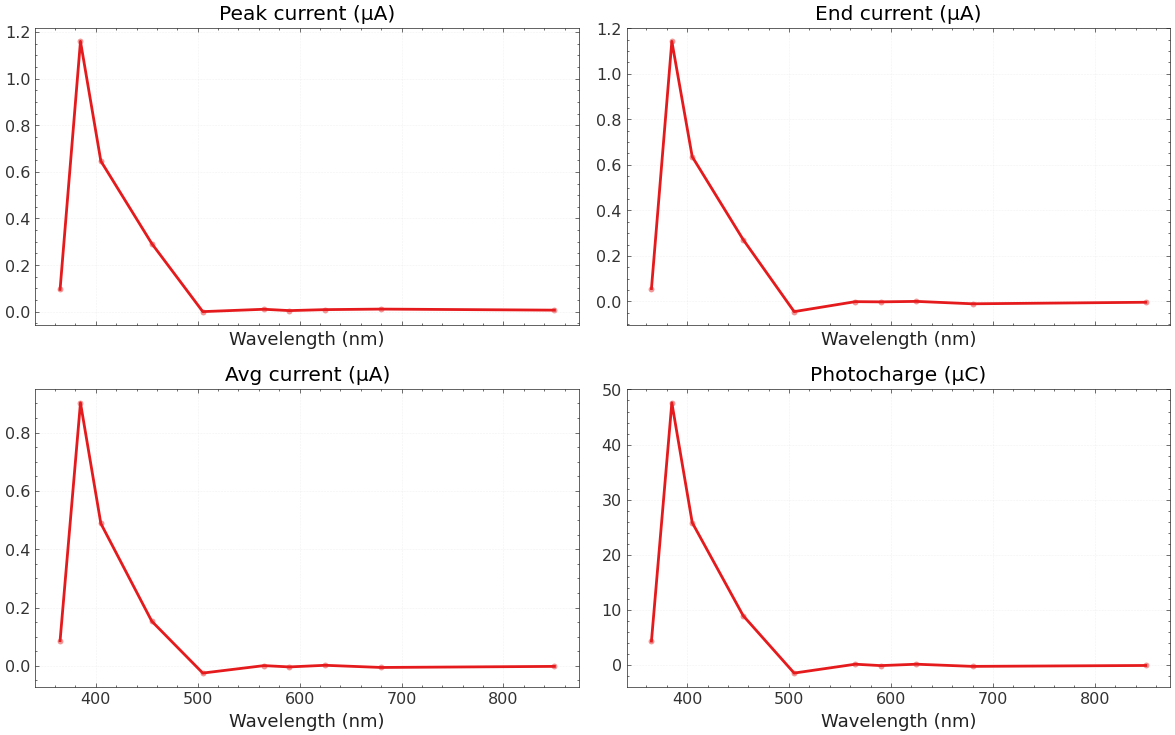

In [21]:
good_its = [1,2,3,4,5,6,7,8,15,16]
meta_only_good_it = meta.filter(
    (pl.col("proc") == "ITS") & pl.col("file_idx").is_in(good_its)
)

metrics_df = compute_its_metrics_for_subset(
    meta_only_good_it, BASE_DIR,
    baseline_t=60.0, edge_frac=0.2, end_tail_s=10.0, smooth_win_s=1.0
)

plot_wavelength_vs_metrics_pl(
    metrics_df,
    out_dir=FIG_DIR,
    metrics=("I_peak_uA","I_end_uA","I_avg_uA","Q_photo_uC"),
    fname=f"chip{int(meta_only_good_it['Chip number'][0])}_wl_vs_metrics_{tag}.png",
)



In [ ]:
import re
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def _sanitize(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", name)

def plot_wavelength_vs_metric_single_pl(
    df: pl.DataFrame,
    metric: str,
    out_path: Path,
    *,
    title: str | None = None,
    x_label: str = "Wavelength (nm)",
    sharex: bool = True,   # kept for API symmetry; single plot ignores
    sharey: bool = False,  # kept for API symmetry; single plot ignores
    dpi: int = 300,
):
    """
    Single-metric plot: wavelength vs <metric> (scatter + median line + IQR band).
    Adds two legends:
      - 'Data' (samples / median / IQR)
      - 'Axes' (x: <label>, y: <label>)
    df must contain: 'wavelength_nm' and <metric>.
    """
    # Guard rails
    if "wavelength_nm" not in df.columns or metric not in df.columns:
        print(f"[warn] missing columns for metric '{metric}'")
        return None

    data = df.filter(pl.col("wavelength_nm").is_finite() & pl.col(metric).is_finite())
    if data.height == 0:
        print(f"[warn] no finite data for '{metric}'")
        return None

    # Grouped stats per wavelength
    grouped = (
        data.group_by("wavelength_nm")
            .agg([
                pl.col(metric).median().alias("med"),
                pl.col(metric).quantile(0.25).alias("q1"),
                pl.col(metric).quantile(0.75).alias("q3"),
            ])
            .sort("wavelength_nm")
    )

    x_all = data["wavelength_nm"].to_numpy()
    y_all = data[metric].to_numpy()

    xg = grouped["wavelength_nm"].to_numpy()
    y_med = grouped["med"].to_numpy()
    y_q1  = grouped["q1"].to_numpy()
    y_q3  = grouped["q3"].to_numpy()

    # Titles / labels
    unit_map = {
        "I_peak_uA":  "Peak current (µA)",
        "I_end_uA":   "End current (µA)",
        "I_avg_uA":   "Avg current (µA)",
        "Q_photo_uC": "Photocharge (µC)",
    }
    if title is None:
        title = unit_map.get(metric, metric)
    y_label = title  # use the descriptive title as the y-axis label

    # Plot
    plt.figure(figsize=(6.5, 4.0))
    ax = plt.gca()

    # Data artists
    sc = ax.scatter(x_all, y_all, s=25, alpha=0.45, linewidths=0)
    ln, = ax.plot(xg, y_med, lw=1)
    band = ax.fill_between(xg, y_q1, y_q3, alpha=0.2, linewidth=0)

    # Axes cosmetics
    #ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    #ax.grid(True, alpha=0.25)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()
    print(f"saved {out_path}")
    return out_path

def plot_wavelength_vs_metrics_pl_separate(
    metrics_df: pl.DataFrame,
    out_dir: Path,
    *,
    metrics = ("I_peak_uA","I_end_uA","I_avg_uA","Q_photo_uC"),
    filename_prefix: str = "wl_vs",
    dpi: int = 300,
) -> dict[str, Path]:
    """
    Create ONE FIGURE PER METRIC. Returns {metric: saved_path}.
    Skips metrics not present in the DataFrame.
    """
    results: dict[str, Path] = {}
    for m in metrics:
        if m not in metrics_df.columns:
            print(f"[info] skipping '{m}' (not found in DataFrame)")
            continue
        fname = f"{_sanitize(filename_prefix)}_{_sanitize(m)}.png"
        out_path = out_dir / fname
        p = plot_wavelength_vs_metric_single_pl(metrics_df, m, out_path, dpi=dpi)
        if p is not None:
            results[m] = p
    return results


In [32]:
good_its = [1,2,3,4,5,6,7,8,15,16]
meta_only_good_it = meta.filter(
    (pl.col("proc") == "ITS") & pl.col("file_idx").is_in(good_its)
)



metrics_df = compute_its_metrics_for_subset(
    meta_only_good_it, BASE_DIR,
    baseline_t=60.0, edge_frac=0.2, end_tail_s=10.0, smooth_win_s=1.0
)

# One PNG per metric
saved = plot_wavelength_vs_metrics_pl_separate(
    metrics_df,
    out_dir=FIG_DIR,
    metrics=("I_peak_uA","I_end_uA","I_avg_uA","Q_photo_uC"),
    filename_prefix=f"chip{int(meta_only_good_it['Chip number'][0])}_{tag}"
)


saved figs/chip81_metadata_I_peak_uA.png
saved figs/chip81_metadata_I_end_uA.png
saved figs/chip81_metadata_I_avg_uA.png
saved figs/chip81_metadata_Q_photo_uC.png
